Enhanced ML-Based Scheduler Performance Evaluation
Dataset loaded with 5000 rows and 11 columns
Extracted 13 features: ['execution_time', 'avg_cpu_usage', 'avg_memory_usage', 'priority', 'scheduling_class', 'cpu_request', 'memory_request', 'machine_id', 'collection_id', 'instance_index', 'cpu_efficiency', 'memory_efficiency', 'resource_ratio']

Performance label distribution:
  Good: 1250 (25.0%)
  Average: 1250 (25.0%)
  Poor: 1250 (25.0%)
  Excellent: 1250 (25.0%)
Training ML models for scheduler performance classification...

Training Random Forest...
  CV Score: 0.8715 ± 0.0186
  Test Accuracy: 0.8950
  Test F1: 0.8954

Training Gradient Boosting...
  CV Score: 0.9223 ± 0.0101
  Test Accuracy: 0.9370
  Test F1: 0.9372

Training SVM...
  CV Score: 0.8520 ± 0.0096
  Test Accuracy: 0.8560
  Test F1: 0.8556

Best model: Gradient Boosting (F1: 0.9372)

MACHINE LEARNING CLASSIFICATION RESULTS

Model Performance Comparison:
            Model  CV Mean  CV Std  Accuracy  Precision  Recall  

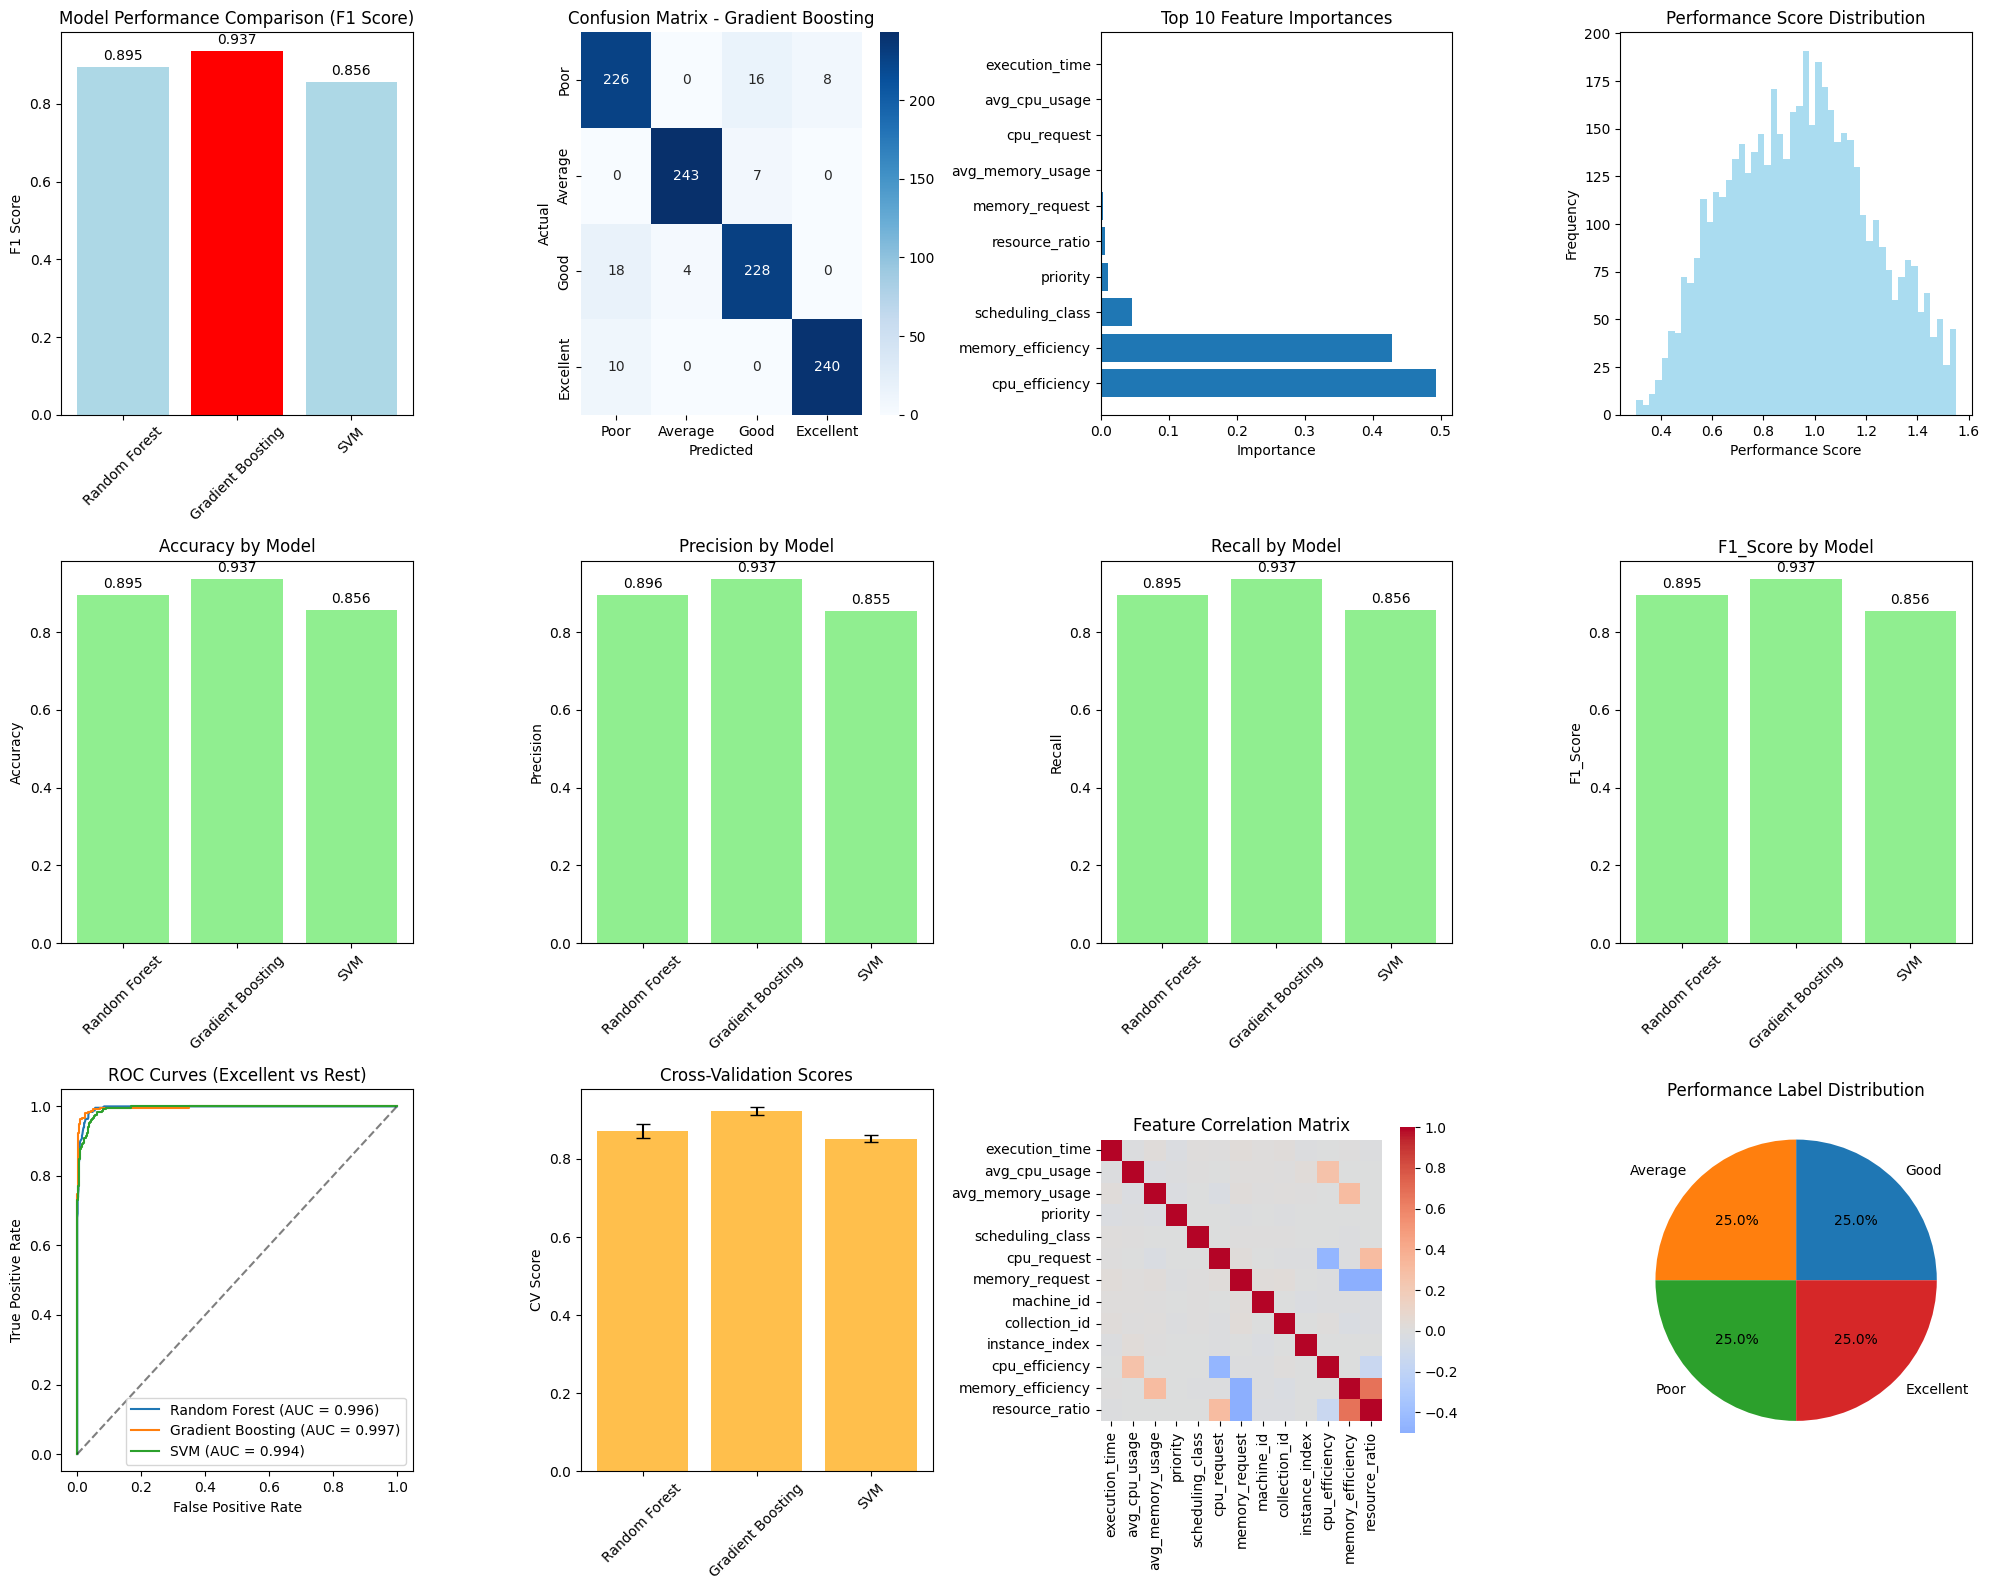


SCHEDULER EVALUATION: Hybrid_FAO_Demo
Predicted Performance: Good
Confidence: 0.5951
Model Used: Gradient Boosting


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                           confusion_matrix, classification_report, roc_curve, auc)
from sklearn.decomposition import PCA
from typing import List, Dict, Tuple, Optional
import warnings
warnings.filterwarnings('ignore')

class MLSchedulerEvaluator:
    """
    Machine Learning based scheduler performance evaluator using real scheduling data
    """

    def __init__(self, dataset_path: Optional[str] = None, dataset_df: Optional[pd.DataFrame] = None):
        self.dataset_df = dataset_df
        self.dataset_path = dataset_path
        self.scaler = StandardScaler()
        self.label_encoder = LabelEncoder()
        self.trained_models = {}
        self.feature_names = []
        self.performance_categories = ['Poor', 'Average', 'Good', 'Excellent']

        if dataset_df is not None:
            self.load_and_preprocess_data()

    def load_and_preprocess_data(self):
        """Load and preprocess the scheduling dataset"""
        if self.dataset_df is None:
            if self.dataset_path:
                self.dataset_df = pd.read_csv(self.dataset_path)
            else:
                raise ValueError("Either dataset_df or dataset_path must be provided")

        print(f"Dataset loaded with {len(self.dataset_df)} rows and {len(self.dataset_df.columns)} columns")

        # Extract relevant features for scheduling performance
        self.extract_scheduling_features()
        self.create_performance_labels()

    def extract_scheduling_features(self):
        """Extract relevant features from the scheduling dataset"""
        features_df = pd.DataFrame()

        # Time-based features
        if 'start_time' in self.dataset_df.columns and 'end_time' in self.dataset_df.columns:
            features_df['execution_time'] = pd.to_numeric(self.dataset_df['end_time'], errors='coerce') - pd.to_numeric(self.dataset_df['start_time'], errors='coerce')
        else:
            features_df['execution_time'] = 0

        # Resource utilization features
        if 'average_usage' in self.dataset_df.columns:
            # Parse CPU and memory usage from dictionary-like strings
            cpu_usage = []
            memory_usage = []
            for usage in self.dataset_df['average_usage']:
                try:
                    if isinstance(usage, str) and 'cpus' in usage:
                        # Extract CPU usage
                        cpu_start = usage.find("'cpus': ") + 8
                        cpu_end = usage.find(",", cpu_start)
                        if cpu_end == -1:
                            cpu_end = usage.find("}", cpu_start)
                        cpu_val = float(usage[cpu_start:cpu_end])
                        cpu_usage.append(cpu_val)

                        # Extract memory usage
                        mem_start = usage.find("'memory': ") + 10
                        mem_end = usage.find("}", mem_start)
                        mem_val = float(usage[mem_start:mem_end])
                        memory_usage.append(mem_val)
                    else:
                        cpu_usage.append(0)
                        memory_usage.append(0)
                except:
                    cpu_usage.append(0)
                    memory_usage.append(0)

            features_df['avg_cpu_usage'] = cpu_usage
            features_df['avg_memory_usage'] = memory_usage
        else:
            features_df['avg_cpu_usage'] = 0
            features_df['avg_memory_usage'] = 0

        # Priority and scheduling class
        features_df['priority'] = pd.to_numeric(self.dataset_df.get('priority', 0), errors='coerce').fillna(0)
        features_df['scheduling_class'] = pd.to_numeric(self.dataset_df.get('scheduling_class', 0), errors='coerce').fillna(0)

        # Resource requests
        if 'resource_request' in self.dataset_df.columns:
            cpu_requests = []
            memory_requests = []
            for req in self.dataset_df['resource_request']:
                try:
                    if isinstance(req, str) and 'cpus' in req:
                        cpu_start = req.find("'cpus': ") + 8
                        cpu_end = req.find(",", cpu_start)
                        if cpu_end == -1:
                            cpu_end = req.find("}", cpu_start)
                        cpu_val = float(req[cpu_start:cpu_end])
                        cpu_requests.append(cpu_val)

                        mem_start = req.find("'memory': ") + 10
                        mem_end = req.find("}", mem_start)
                        mem_val = float(req[mem_start:mem_end])
                        memory_requests.append(mem_val)
                    else:
                        cpu_requests.append(0)
                        memory_requests.append(0)
                except:
                    cpu_requests.append(0)
                    memory_requests.append(0)

            features_df['cpu_request'] = cpu_requests
            features_df['memory_request'] = memory_requests
        else:
            features_df['cpu_request'] = 0
            features_df['memory_request'] = 0

        # Machine and collection features
        features_df['machine_id'] = pd.to_numeric(self.dataset_df.get('machine_id', 0), errors='coerce').fillna(0)
        features_df['collection_id'] = pd.to_numeric(self.dataset_df.get('collection_id', 0), errors='coerce').fillna(0)
        features_df['instance_index'] = pd.to_numeric(self.dataset_df.get('instance_index', 0), errors='coerce').fillna(0)

        # Additional computed features
        features_df['cpu_efficiency'] = features_df['avg_cpu_usage'] / (features_df['cpu_request'] + 1e-10)
        features_df['memory_efficiency'] = features_df['avg_memory_usage'] / (features_df['memory_request'] + 1e-10)
        features_df['resource_ratio'] = features_df['cpu_request'] / (features_df['memory_request'] + 1e-10)

        # Handle infinite values
        features_df = features_df.replace([np.inf, -np.inf], np.nan).fillna(0)

        self.features_df = features_df
        self.feature_names = features_df.columns.tolist()

        print(f"Extracted {len(self.feature_names)} features: {self.feature_names}")

    def create_performance_labels(self):
        """Create performance labels based on scheduling metrics"""
        # Calculate composite performance score
        performance_scores = []

        for idx, row in self.features_df.iterrows():
            score = 0

            # CPU efficiency component (30%)
            cpu_eff = min(row['cpu_efficiency'], 2.0)  # Cap at 2.0 to avoid extreme values
            score += 0.3 * cpu_eff

            # Memory efficiency component (25%)
            mem_eff = min(row['memory_efficiency'], 2.0)
            score += 0.25 * mem_eff

            # Execution time component (25%) - normalized and inverted
            if row['execution_time'] > 0:
                exec_time_norm = 1.0 / (1.0 + row['execution_time'] / 1e12)  # Normalize large time values
                score += 0.25 * exec_time_norm

            # Priority consideration (10%)
            priority_norm = min(row['priority'] / 10.0, 1.0)  # Normalize priority
            score += 0.1 * priority_norm

            # Scheduling class bonus (10%)
            if row['scheduling_class'] in [2, 3]:  # Assuming these are better scheduling classes
                score += 0.1

            performance_scores.append(score)

        # Convert scores to categories using quartiles
        score_quartiles = np.percentile(performance_scores, [25, 50, 75])

        labels = []
        for score in performance_scores:
            if score <= score_quartiles[0]:
                labels.append('Poor')
            elif score <= score_quartiles[1]:
                labels.append('Average')
            elif score <= score_quartiles[2]:
                labels.append('Good')
            else:
                labels.append('Excellent')

        self.performance_scores = performance_scores
        self.performance_labels = labels

        # Print label distribution
        label_counts = pd.Series(labels).value_counts()
        print(f"\nPerformance label distribution:")
        for label, count in label_counts.items():
            print(f"  {label}: {count} ({count/len(labels)*100:.1f}%)")

    def train_classification_models(self):
        """Train multiple classification models"""
        X = self.features_df
        y = self.performance_labels

        # Encode labels
        y_encoded = self.label_encoder.fit_transform(y)

        # Split data
        X_train, X_test, y_train, y_test = train_test_split(
            X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
        )

        # Scale features
        X_train_scaled = self.scaler.fit_transform(X_train)
        X_test_scaled = self.scaler.transform(X_test)

        # Store test data for evaluation
        self.X_test = X_test_scaled
        self.y_test = y_test
        self.y_test_labels = self.label_encoder.inverse_transform(y_test)

        # Define models
        models = {
            'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
            'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
            'SVM': SVC(kernel='rbf', random_state=42, probability=True)
        }

        # Train and evaluate models
        model_results = {}

        for name, model in models.items():
            print(f"\nTraining {name}...")

            # Train model
            model.fit(X_train_scaled, y_train)

            # Cross-validation
            cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5)

            # Test predictions
            y_pred = model.predict(X_test_scaled)
            y_pred_proba = model.predict_proba(X_test_scaled) if hasattr(model, 'predict_proba') else None

            # Calculate metrics
            accuracy = accuracy_score(y_test, y_pred)
            precision = precision_score(y_test, y_pred, average='weighted')
            recall = recall_score(y_test, y_pred, average='weighted')
            f1 = f1_score(y_test, y_pred, average='weighted')

            model_results[name] = {
                'model': model,
                'cv_mean': cv_scores.mean(),
                'cv_std': cv_scores.std(),
                'accuracy': accuracy,
                'precision': precision,
                'recall': recall,
                'f1_score': f1,
                'y_pred': y_pred,
                'y_pred_proba': y_pred_proba,
                'confusion_matrix': confusion_matrix(y_test, y_pred)
            }

            print(f"  CV Score: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
            print(f"  Test Accuracy: {accuracy:.4f}")
            print(f"  Test F1: {f1:.4f}")

        self.trained_models = model_results

        # Select best model
        best_model_name = max(model_results.keys(), key=lambda x: model_results[x]['f1_score'])
        self.best_model_name = best_model_name
        self.best_model = model_results[best_model_name]['model']

        print(f"\nBest model: {best_model_name} (F1: {model_results[best_model_name]['f1_score']:.4f})")

        return model_results

    def evaluate_scheduler_performance(self, scheduler_mapping: List[int],
                                     scheduler_features: Dict[str, float],
                                     algorithm_name: str = "Custom_Scheduler"):
        """Evaluate a scheduler using the trained ML model"""
        if not self.trained_models:
            raise ValueError("Models not trained. Call train_classification_models() first.")

        # Prepare scheduler features
        feature_vector = np.zeros(len(self.feature_names))
        for i, feature_name in enumerate(self.feature_names):
            if feature_name in scheduler_features:
                feature_vector[i] = scheduler_features[feature_name]

        # Scale features
        feature_vector_scaled = self.scaler.transform(feature_vector.reshape(1, -1))

        # Get predictions from all models
        predictions = {}
        for model_name, model_data in self.trained_models.items():
            model = model_data['model']
            pred_class = model.predict(feature_vector_scaled)[0]
            pred_proba = model.predict_proba(feature_vector_scaled)[0] if hasattr(model, 'predict_proba') else None

            predictions[model_name] = {
                'predicted_class': self.label_encoder.inverse_transform([pred_class])[0],
                'predicted_probabilities': pred_proba,
                'confidence': max(pred_proba) if pred_proba is not None else None
            }

        # Use best model for final prediction
        best_prediction = predictions[self.best_model_name]

        return {
            'algorithm_name': algorithm_name,
            'predicted_performance': best_prediction['predicted_class'],
            'confidence': best_prediction['confidence'],
            'all_predictions': predictions,
            'feature_vector': scheduler_features,
            'model_used': self.best_model_name
        }

    def print_classification_results(self):
        """Print detailed classification results"""
        if not self.trained_models:
            print("No trained models available.")
            return

        print("\n" + "="*80)
        print("MACHINE LEARNING CLASSIFICATION RESULTS")
        print("="*80)

        # Model comparison table
        results_df = pd.DataFrame({
            'Model': list(self.trained_models.keys()),
            'CV Mean': [r['cv_mean'] for r in self.trained_models.values()],
            'CV Std': [r['cv_std'] for r in self.trained_models.values()],
            'Accuracy': [r['accuracy'] for r in self.trained_models.values()],
            'Precision': [r['precision'] for r in self.trained_models.values()],
            'Recall': [r['recall'] for r in self.trained_models.values()],
            'F1 Score': [r['f1_score'] for r in self.trained_models.values()]
        })

        print("\nModel Performance Comparison:")
        print(results_df.round(4).to_string(index=False))

        # Best model details
        best_results = self.trained_models[self.best_model_name]
        print(f"\nBest Model: {self.best_model_name}")
        print(f"Test Set Performance:")
        print(f"  Accuracy:  {best_results['accuracy']:.4f}")
        print(f"  Precision: {best_results['precision']:.4f}")
        print(f"  Recall:    {best_results['recall']:.4f}")
        print(f"  F1 Score:  {best_results['f1_score']:.4f}")

        # Classification report
        y_pred_labels = self.label_encoder.inverse_transform(best_results['y_pred'])
        print(f"\nDetailed Classification Report ({self.best_model_name}):")
        print(classification_report(self.y_test_labels, y_pred_labels))

        # Feature importance (for tree-based models)
        if hasattr(best_results['model'], 'feature_importances_'):
            feature_importance = pd.DataFrame({
                'Feature': self.feature_names,
                'Importance': best_results['model'].feature_importances_
            }).sort_values('Importance', ascending=False)

            print(f"\nTop 10 Most Important Features ({self.best_model_name}):")
            print(feature_importance.head(10).to_string(index=False))

    def visualize_classification_results(self):
        """Create comprehensive visualizations"""
        if not self.trained_models:
            print("No trained models to visualize.")
            return

        fig = plt.figure(figsize=(20, 16))

        # 1. Model Performance Comparison
        plt.subplot(3, 4, 1)
        models = list(self.trained_models.keys())
        f1_scores = [self.trained_models[m]['f1_score'] for m in models]

        bars = plt.bar(models, f1_scores, color=['red' if m == self.best_model_name else 'lightblue' for m in models])
        plt.title('Model Performance Comparison (F1 Score)')
        plt.ylabel('F1 Score')
        plt.xticks(rotation=45)

        # Highlight best model
        for i, (model, score) in enumerate(zip(models, f1_scores)):
            plt.text(i, score + 0.01, f'{score:.3f}', ha='center', va='bottom')

        # 2. Confusion Matrix for Best Model
        plt.subplot(3, 4, 2)
        best_cm = self.trained_models[self.best_model_name]['confusion_matrix']
        sns.heatmap(best_cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=self.performance_categories,
                   yticklabels=self.performance_categories)
        plt.title(f'Confusion Matrix - {self.best_model_name}')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')

        # 3. Feature Importance (if available)
        plt.subplot(3, 4, 3)
        if hasattr(self.trained_models[self.best_model_name]['model'], 'feature_importances_'):
            importances = self.trained_models[self.best_model_name]['model'].feature_importances_
            indices = np.argsort(importances)[::-1][:10]

            plt.barh(range(10), importances[indices])
            plt.yticks(range(10), [self.feature_names[i] for i in indices])
            plt.title('Top 10 Feature Importances')
            plt.xlabel('Importance')

        # 4. Performance Score Distribution
        plt.subplot(3, 4, 4)
        plt.hist(self.performance_scores, bins=50, alpha=0.7, color='skyblue')
        plt.title('Performance Score Distribution')
        plt.xlabel('Performance Score')
        plt.ylabel('Frequency')

        # 5-8. Class-wise Performance Analysis
        for i, metric in enumerate(['accuracy', 'precision', 'recall', 'f1_score']):
            plt.subplot(3, 4, 5+i)
            values = [self.trained_models[m][metric] for m in models]
            plt.bar(models, values, color='lightgreen')
            plt.title(f'{metric.title()} by Model')
            plt.ylabel(metric.title())
            plt.xticks(rotation=45)

            for j, v in enumerate(values):
                plt.text(j, v + 0.01, f'{v:.3f}', ha='center', va='bottom')

        # 9. ROC Curves (if probabilities available)
        plt.subplot(3, 4, 9)
        for model_name, model_data in self.trained_models.items():
            if model_data['y_pred_proba'] is not None:
                # For multiclass, plot ROC for each class
                y_test_bin = (self.y_test == 3).astype(int)  # Example: Excellent vs Rest
                y_pred_proba_bin = model_data['y_pred_proba'][:, 3]  # Probability of Excellent

                fpr, tpr, _ = roc_curve(y_test_bin, y_pred_proba_bin)
                roc_auc = auc(fpr, tpr)

                plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.3f})')

        plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curves (Excellent vs Rest)')
        plt.legend()

        # 10. Cross-validation Scores
        plt.subplot(3, 4, 10)
        cv_means = [self.trained_models[m]['cv_mean'] for m in models]
        cv_stds = [self.trained_models[m]['cv_std'] for m in models]

        plt.bar(models, cv_means, yerr=cv_stds, capsize=5, color='orange', alpha=0.7)
        plt.title('Cross-Validation Scores')
        plt.ylabel('CV Score')
        plt.xticks(rotation=45)

        # 11. Feature Correlation Matrix
        plt.subplot(3, 4, 11)
        correlation_matrix = self.features_df.corr()
        sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', center=0,
                   square=True, cbar_kws={'shrink': 0.8})
        plt.title('Feature Correlation Matrix')

        # 12. Label Distribution
        plt.subplot(3, 4, 12)
        label_counts = pd.Series(self.performance_labels).value_counts()
        plt.pie(label_counts.values, labels=label_counts.index, autopct='%1.1f%%')
        plt.title('Performance Label Distribution')

        plt.tight_layout()
        plt.show()

# Integration function for your existing scheduler
def evaluate_scheduler_with_ml(dataset_df, scheduler_mapping, scheduler_metrics, algorithm_name="Hybrid_FAO"):
    """
    Enhanced evaluation function using ML classification

    Args:
        dataset_df: Your scheduling dataset
        scheduler_mapping: List of VM assignments for tasks
        scheduler_metrics: Dict with scheduler performance metrics
        algorithm_name: Name of your scheduler algorithm
    """
    # Initialize evaluator
    evaluator = MLSchedulerEvaluator(dataset_df=dataset_df)

    # Train models
    print("Training ML models for scheduler performance classification...")
    model_results = evaluator.train_classification_models()

    # Print results
    evaluator.print_classification_results()

    # Visualize results
    evaluator.visualize_classification_results()

    # Evaluate your scheduler
    scheduler_prediction = evaluator.evaluate_scheduler_performance(
        scheduler_mapping, scheduler_metrics, algorithm_name
    )

    print(f"\n" + "="*60)
    print(f"SCHEDULER EVALUATION: {algorithm_name}")
    print("="*60)
    print(f"Predicted Performance: {scheduler_prediction['predicted_performance']}")
    print(f"Confidence: {scheduler_prediction['confidence']:.4f}")
    print(f"Model Used: {scheduler_prediction['model_used']}")

    return {
        'model_results': model_results,
        'scheduler_prediction': scheduler_prediction,
        'evaluator': evaluator
    }

# Demo function with sample data structure
def demo_ml_evaluation():
    """Demo with sample data that matches your dataset structure"""
    # Create sample data matching your dataset structure
    np.random.seed(42)
    n_samples = 5000

    sample_data = {
        'time': np.random.randint(0, 1000, n_samples),
        'instance_events_type': np.random.randint(0, 3, n_samples),
        'collection_id': np.random.randint(0, 1000, n_samples),
        'scheduling_class': np.random.randint(0, 4, n_samples),
        'priority': np.random.randint(0, 11, n_samples),
        'machine_id': np.random.randint(0, 500, n_samples),
        'start_time': np.random.randint(0, 1000000, n_samples),
        'end_time': np.random.randint(1000000, 2000000, n_samples),
        'average_usage': [f"{{'cpus': {np.random.uniform(0, 0.1):.6f}, 'memory': {np.random.uniform(0, 0.05):.6f}}}"
                         for _ in range(n_samples)],
        'resource_request': [f"{{'cpus': {np.random.uniform(0.001, 0.1):.6f}, 'memory': {np.random.uniform(0.001, 0.05):.6f}}}"
                            for _ in range(n_samples)],
        'instance_index': np.random.randint(0, 100, n_samples),
    }

    sample_df = pd.DataFrame(sample_data)

    # Sample scheduler results
    scheduler_mapping = np.random.randint(0, 10, 1000).tolist()
    scheduler_metrics = {
        'execution_time': 150000,
        'avg_cpu_usage': 0.045,
        'avg_memory_usage': 0.025,
        'priority': 5,
        'scheduling_class': 2,
        'cpu_request': 0.03,
        'memory_request': 0.02,
        'machine_id': 150,
        'collection_id': 500,
        'instance_index': 50,
        'cpu_efficiency': 1.5,
        'memory_efficiency': 1.25,
        'resource_ratio': 1.5
    }

    # Run evaluation
    results = evaluate_scheduler_with_ml(
        sample_df, scheduler_mapping, scheduler_metrics, "Hybrid_FAO_Demo"
    )

    return results

if __name__ == "__main__":
    print("Enhanced ML-Based Scheduler Performance Evaluation")
    print("="*60)
    demo_results = demo_ml_evaluation()